In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
sns.set()
matplotlib.rcParams['figure.dpi'] = 81
os.chdir('/Users/bmr225/Documents/WorldQuantUniversity')

In [3]:
# To hide all the warnings in Python
import warnings
warnings.filterwarnings('ignore')

# ML Miniproject: World Quant University Data Science Module II
## Introduction

The objective of this miniproject is to create effective machine learning models for making predictions. We are  working with nursing home inspection data (which is a clean dataset) from the United States, predicting which providers may be fined and for how much.



## Downloading the data

We can download the data set from Amazon S3:

In [4]:
%%bash
mkdir data
wget http://dataincubator-wqu.s3.amazonaws.com/mldata/providers-train.csv -nc -P ./ml-data
wget http://dataincubator-wqu.s3.amazonaws.com/mldata/providers-metadata.csv -nc -P ./ml-data

mkdir: data: File exists
File ‘./ml-data/providers-train.csv’ already there; not retrieving.

File ‘./ml-data/providers-metadata.csv’ already there; not retrieving.



In [5]:
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/mldata/providers-train.csv" -nc -P ./ml-data/')
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/mldata/providers-metadata.csv" -nc -P ./ml-data/')

0

We'll load the data into a Pandas DataFrame. 'fine_totals' and 'cycle2_score' will become target labels in future investigations. Let's pop those columns out from the data, and drop related columns that are neither targets nor reasonable features (i.e. we don't wouldn't know how many times a facility denied payment before knowing whether it was fined).


In [6]:
data = pd.read_csv('./ml-data/providers-train.csv', encoding='latin1')

fine_counts = data.pop('FINE_CNT')
fine_totals = data.pop('FINE_TOT')
cycle_2_score = data.pop('CYCLE_2_TOTAL_SCORE')

In [7]:
data.head()

,PROVNUM,PROVNAME,ADDRESS,CITY,STATE,ZIP,PHONE,COUNTY_SSA,COUNTY_NAME,BEDCERT,...,CERTIFICATION,CYCLE_1_DEFS,CYCLE_1_NFROMDEFS,CYCLE_1_NFROMCOMP,CYCLE_1_DEFS_SCORE,CYCLE_1_NUMREVIS,CYCLE_1_REVISIT_SCORE,CYCLE_1_TOTAL_SCORE,CYCLE_1_SURVEY_DATE,CYCLE_2_SURVEY_DATE
0,015010,COOSA VALLEY NURSING FACILITY,315 WEST HICKORY STREET,SYLACAUGA,AL,35150,2562495604,600,Talladega,85,...,Medicare and Medicaid,7,7,0,36,1,0,36,2017-04-06,2016-05-26
1,015012,HIGHLANDS HEALTH AND REHAB,380 WOODS COVE ROAD,SCOTTSBORO,AL,35768,2562183708,350,Jackson,50,...,Medicare and Medicaid,5,5,0,44,1,0,44,2017-03-16,2016-02-04
2,015014,EASTVIEW REHABILITATION & HEALTHCARE CENTER,7755 FOURTH AVENUE SOUTH,BIRMINGHAM,AL,35206,2058330146,360,Jefferson,92,...,Medicare and Medicaid,6,6,0,40,1,0,40,2016-10-20,2015-12-30
3,015015,PLANTATION MANOR NURSING HOME,6450 OLD TUSCALOOSA HIGHWAY P O BOX 97,MC CALLA,AL,35111,2054776161,360,Jefferson,103,...,Medicare and Medicaid,2,2,0,16,1,0,16,2017-03-09,2016-02-11
4,015016,ATHENS HEALTH AND REHABILITATION LLC,611 WEST MARKET STREET,ATHENS,AL,35611,2562321620,410,Limestone,149,...,Medicare and Medicaid,2,2,0,20,1,0,20,2017-06-01,2016-05-12


In [8]:
data.iloc[100]

PROVNUM                                    015191
PROVNAME                       BROWN NURSING HOME
ADDRESS                    2334 WASHINGTON STREET
CITY                               ALEXANDER CITY
STATE                                          AL
ZIP                                         35010
PHONE                                  2563299061
COUNTY_SSA                                    610
COUNTY_NAME                            Tallapoosa
BEDCERT                                        68
RESTOT                                         64
INHOSP                                      False
CCRC_FACIL                                  False
SFF                                         False
CHOW_LAST_12MOS                             False
SPRINKLER_STATUS                             True
EXP_TOTAL                                 3.11597
ADJ_TOTAL                                 4.32728
OWNERSHIP                For profit - Corporation
CERTIFICATION               Medicare and Medicaid


## Objective I: Prediction of whether the facility is fined or not/Classification

A federal agency, Centers for Medicare and Medicaid Services (CMS), imposes regulations on nursing homes. However, nursing homes are inspected by state agencies for compliance with regulations, and fines for violations can vary widely between states.

Nursing homes vary greatly in their business characteristics. Some are owned by the government or non-profits while others are run for profit. Some house a few dozen residents while others house hundreds. Some are located within hospitals and may work with more vulnerable populations. We will try to predict which facilities are fined based on their business characteristics.

We'll begin with columns in our DataFrame containing numeric and boolean features. Some of the rows contain null values; estimators cannot handle null values so these must be imputed or dropped. We will create a `Pipeline` containing transformers that process these features, followed by an estimator.

My model must work with both data types. For this reason, we've provided a custom `ColumnSelectTransformer` for you to use instead `scikit-learn`'s own `ColumnTransformer`.

In [9]:
data_all= data.copy()
Is_fined = fine_counts > 0
data_all['Is_fined'] = Is_fined
data_all['Fine_Tot'] = fine_totals

### Proportion of facilities that were fined

In [23]:
sum(fine_counts > 0)/len(fine_counts) # 31% Got fine, 70% percent 

0.3080909876187734

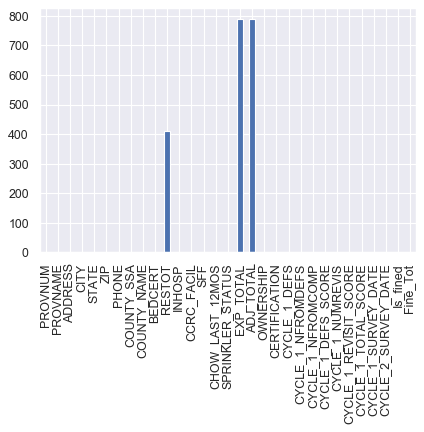

In [10]:
data_all.isnull().sum().plot(kind = 'bar')

Three numeric columns have null values. 

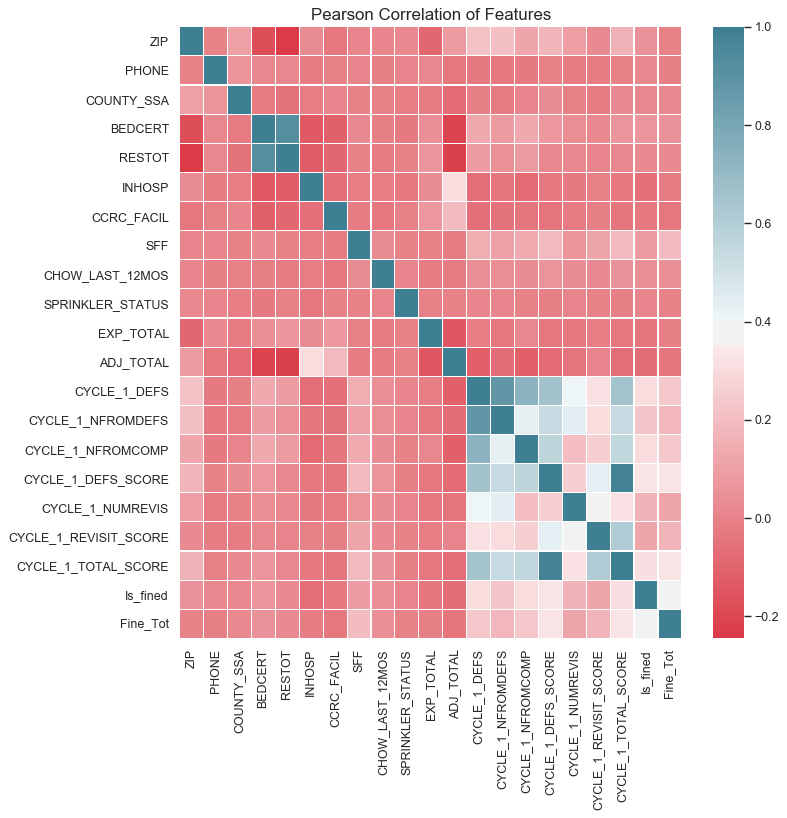

In [11]:
# There are 29 columns: How many to choose to predict fines or not fined...
import ppscore as pps
#corr_matrix = pps.matrix(data_all) # PPS take a long time
corr_matrix = data_all.corr()
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10,220,as_cmap = True)

sns.heatmap(corr_matrix, 
            cmap = colormap,
            annot = False,
           linewidths = 0.1, vmax = 1.0, linecolor='white',
           annot_kws = {'fontsize':12})
plt.show()

Based on this, RESTOT and BEDCERT are correlated so one of them can be eliminated. 

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Simple Features: Numerical and Boolean Features

### Imputation (strategy = 'mean')

In [8]:
simple_cols = ['ZIP','BEDCERT','RESTOT','INHOSP', 'CCRC_FACIL', 'SFF', 'CHOW_LAST_12MOS', 'SPRINKLER_STATUS', 'EXP_TOTAL', 'ADJ_TOTAL']

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):# if not a dataframe, convert to a data frame...
            X = pd.DataFrame(X) 
                   
        #Subsetting the data
        X_select = X[self.columns]
        
        # Find cols with missing data
        na_l = X_select.isna().any()
        
        # Indices of columns with nan.. FALSE in this case
        nan_indices = [i for i, x in enumerate(na_l) if x]
     
        # columns are numerical
        nan_cols = [self.columns[ind] for ind in nan_indices]
        
        # Imputer
        imp = SimpleImputer(strategy = 'mean')
        
        for col in nan_cols: 
         
            X_col = X_select[col].values
            d = imp.fit_transform(X_col.reshape(-1,1))
            X.loc[:,col]= sum((d.reshape(1,-1)).tolist(),[]) 
            
                           
        return X[self.columns]  

In [9]:
simple_features = Pipeline([
    ('cst', ColumnSelectTransformer(simple_cols)),
])

## Categorical Features

### One hot encoding

The `'OWNERSHIP'` and `'CERTIFICATION'` columns contain categorical data. We will have to encode the categorical data into numerical features before we pass them to an estimator. Construct one or more pipelines for this purpose. Transformers such as [LabelEncoder](https://scikit-learn.org/0.19/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) and [OneHotEncoder](https://scikit-learn.org/0.19/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) may be useful, but you may also want to define your own transformers.



In [50]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame): # if not a dataframe, convert to a data frame...
            X = pd.DataFrame(X) 
        
        #label encoder    
        encoder = LabelEncoder()       
        Xt = encoder.fit_transform(X[self.column]) 
        cols = list(encoder.classes_) 
        
        # One hot encoder
        One_hot = OneHotEncoder() # you can specify sparse = False
        Xtt = One_hot.fit_transform(Xt.reshape(-1,1))
        Xtt = Xtt.toarray()
        
        # Creating new data cols
        i = 0
        for col in cols:
            X[col]=Xtt[:,i]
            i+=1
        
        return X[cols]

When using more than one `Pipeline`, we combine them with a `FeatureUnion`. 

In [51]:
from sklearn.pipeline import FeatureUnion

owner_onehot = Pipeline([
    ('cst', ColumnSelectTransformer(['OWNERSHIP'])),
])


cert_onehot = Pipeline([
    ('cst', ColumnSelectTransformer(['CERTIFICATION'])),
])

categorical_features = FeatureUnion([('pipe_onehot1',owner_onehot), ('pipe_onehot2',cert_onehot)
])

### Feature Union of both numeric and categorical features into the model
### Business Features = Numerical + Boolean + Categorical Features

In [52]:
business_features = FeatureUnion([
    ('simple', simple_features),
    ('categorical', categorical_features)
])

### Hypertuning of RandomForestClassifier

In [19]:
# The problem here is classification
#Hypertuning the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(data,fine_counts > 0, test_size=0.2, random_state=0)

classifier = RandomForestClassifier(random_state = 0)

param_grid = {'max_depth':range(1,20),
              'criterion':['gini','entropy'],
              'min_samples_leaf': range(2,100,2),
              'min_samples_split': [2, 4, 6, 8, 10],
              'n_estimators':range(50,200,50),
              'max_features':['log2','sqrt']}

random_search = RandomizedSearchCV(classifier, param_grid, cv=5,n_jobs = 2,n_iter=10, verbose = 1)

business_model_2 = Pipeline([
    ('features', business_features),
    # add your estimator here
    ('random_search',random_search)
])

business_model_2.fit(X_train,y_train)


print('Training accuracy:{}'.format(business_model_2.score(X_train,y_train)))
print('Test accuracy:{}'.format(business_model_2.score(X_test,y_test)))
print(business_model_2.named_steps['random_search'].best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Training accuracy:0.7056600377935751
Test accuracy:0.7081684059014034
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 17, 'criterion': 'entropy'}


In [16]:
estimator_model = Pipeline([('forest_classifier', RandomForestClassifier(n_estimators = 150, criterion ='entropy', min_samples_split =10, min_samples_leaf= 10, max_features= 'sqrt',max_depth=11))])

### Pipeline: Business Features  Model

In [17]:
business_model = Pipeline([
    ('features', business_features),
    # add your estimator here
    ('estimator', estimator_model)
])

In [18]:
business_model.fit(data, fine_counts > 0)
y_pred = business_model.predict(data)

## Model Performance

In [19]:
from sklearn import metrics
from sklearn.metrics import f1_score
print("accuracy: {}".format(metrics.accuracy_score(fine_counts > 0, y_pred)))
print('f1 score: {}'.format(f1_score(fine_counts > 0, y_pred, average='weighted')))

accuracy: 0.7048661099913619
f1 score: 0.6011701492422072


## Objective II: Predicting Fine Amounts

In [71]:
# Load the data
data = pd.read_csv('./ml-data/providers-train.csv', encoding='latin1')

fine_counts = data.pop('FINE_CNT')
fine_totals = data.pop('FINE_TOT')


In [21]:
# To select data with fines
ind = [i for i, x in enumerate(fine_totals.to_list()) if x]
data_fine = data.iloc[ind,:]
fine_totals_fined = fine_totals.iloc[ind]

In [27]:
# The problem now is Regression
#Hypertuning the model


from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)

regressor = RandomForestRegressor(random_state = 0)

param_grid = {'max_depth':range(1,20),
              'criterion':['mse','mae'],
              'min_samples_leaf': range(2,100,2),
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_impurity_split':np.logspace(-7,-4,10),
              'n_estimators':range(50,200,50),
              'max_features':['log2','sqrt']}

random_search = RandomizedSearchCV(regressor, param_grid, cv=5,n_jobs = 2,n_iter=10, verbose = 1)

business_model_regress = Pipeline([
    ('features', business_features),
    # add your estimator here
    ('random_search',random_search)
])

business_model_regress.fit(X_train,y_train)


print('Training R^2:{}'.format(business_model_regress.score(X_train,y_train)))
print('Test R^2:{}'.format(business_model_regress.score(X_test,y_test)))
print(business_model_regress.named_steps['random_search'].best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Training R^2:0.07353647181277367
Test R^2:0.048520967292998485
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 40, 'min_impurity_split': 4.641588833612782e-07, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'mse'}


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_cla

### Estimator Pipeline

In [24]:
estimator_model = Pipeline([('regressor', RandomForestRegressor(n_estimators = 100, criterion ='mse', min_samples_split =6, min_samples_leaf= 20,  max_features= 'sqrt',max_depth=19))])

### Building the Model

In [25]:
business_model = Pipeline([
    ('features', business_features),
    # add your estimator here
    ('estimator', estimator_model)
])


business_model.fit(data_fine, fine_totals_fined)
y_pred = business_model.predict(data_fine)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals_fined,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals_fined,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals_fined,y_pred)))


MSE: 7615584064.671905
MAE: 46286.003336
R^2: 0.12946051969882844


### Challenge: How to improve the model performance in predicting fine amounts

In [30]:
# How to improve the model performance
data_fine_all = data_fine.copy()
data_fine_all['Fine_Tot'] = fine_totals_fined

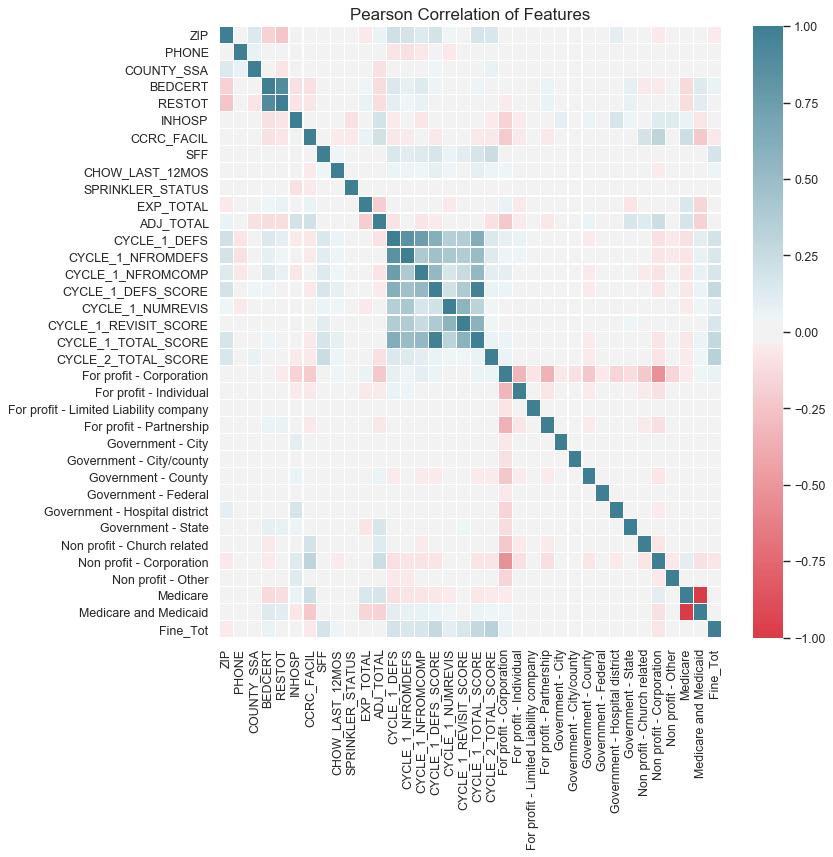

In [31]:
corr_matrix = data_fine_all.corr()
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10,220,as_cmap = True)

sns.heatmap(corr_matrix, 
            cmap = colormap,
            annot = False,
           linewidths = 0.1, vmax = 1.0, linecolor='white',
           annot_kws = {'fontsize':12})
plt.show()

As we can see, the cycle1 variables are highly correlated with each others, we might need to ony keep only 1 variable such as cycle_1_Total_Score. 

### Implementation I: Inclusion of Cycle1 and Cyle2 Scores

In [26]:
class CyclesColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        
        if not isinstance(X, pd.DataFrame): # if not a dataframe, convert to a data frame...
            X = pd.DataFrame(X)
            
        X_new = X.loc[:,self.columns]   
        return X_new 

In [57]:
cycle_1and2_cols = ['CYCLE_1_TOTAL_SCORE','CYCLE_2_TOTAL_SCORE']

#Initiating the transformer
cycle_1and2_features = CyclesColumn(cycle_1and2_cols)

### A. Building simple linear regression model to get a baseline performance

In [60]:
# After including more features of cycle1 and cycle2 scores
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

linear_model = Pipeline([('scaler',StandardScaler()), ('regressor',LinearRegression())])


In [61]:
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', linear_model)  
    ])    

prediction_model.fit(data_fine, fine_totals_fined)
y_pred = prediction_model.predict(data_fine)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals_fined,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals_fined,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals_fined,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))

MSE: 6955777045.668403
MAE: 41288.338553
R^2: 0.20488323902601902
Training R^2:0.20271381189878157
Test R^2:0.20145738456180695


### B. Ensemble Model I: RandomForestRegressor

In [34]:
# RandomForestRegressor
# Tuning the model hyperparameters

# To hide all the warnings in Python
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)

regressor = RandomForestRegressor(random_state = 0)

param_grid = {'max_depth':range(5,15),
              'criterion':['mse','mae'],
              'min_samples_leaf': range(2,20,2),
              'min_samples_split': [2, 4, 6, 8, 10],
              'n_estimators':range(200,500,50),
              'max_features':['log2','sqrt']}

random_search = RandomizedSearchCV(regressor, param_grid, cv=5,n_jobs = 2,n_iter=10, verbose = 1)

business_model_regress = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('random_search',random_search)  
    ])    
business_model_regress.fit(X_train,y_train)


print('Training R^2:{}'.format(business_model_regress.score(X_train,y_train)))
print('Test R^2:{}'.format(business_model_regress.score(X_test,y_test)))
print(business_model_regress.named_steps['random_search'].best_params_)


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.5min finished
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the 

/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_cla

/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_cla

/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_cla

Training R^2:0.2188301744689648
Test R^2:0.19071560736041415
{'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 16, 'min_impurity_split': 1e-06, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'mse'}


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_cla

In [34]:
estimator_model = Pipeline([('regressor',RandomForestRegressor(n_estimators=350, max_depth = 7, min_samples_split=4, min_samples_leaf=16, max_features = 'log2' ))])

In [35]:
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', estimator_model)  
    ])    

prediction_model.fit(data_fine, fine_totals_fined)
y_pred = prediction_model.predict(data_fine)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals_fined,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals_fined,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals_fined,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))

MSE: 6865192799.154075
MAE: 41549.325877
R^2: 0.21523794881772984
Training R^2:0.21590228206256434
Test R^2:0.18364017378818964


In [195]:
# Unfortunately, there was overfitting and lower performance by randomforest, despite the regularization, relative to a simple linear regression model!

###  C. Ensemble Model II: XGBoost

In [225]:
# XGBoost
# Simple approach to know where to start
# The problem now is Regression
# Hypertuning the model

# To hide all the warnings in Python
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)


regressor = xgb.XGBRegressor(random_state = 0)


param_grid = {'n_estimators':range(10,50,5),
             'reg_lambda':np.arange(1,3,0.25),
             'max_depth':range(2,6),
             'min_child_weight':range(2,8),
             'subsample':np.arange(0.2,1,0.2),
             'eta':np.arange(0,1,0.1)}
            

grid_search = GridSearchCV(regressor, param_grid, cv=5,n_jobs = 2, verbose = 1)

business_model_regress = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('grid_search',grid_search)  
    ])    
business_model_regress.fit(X_train,y_train)


print('Training R^2:{}'.format(business_model_regress.score(X_train,y_train)))
print('Test R^2:{}'.format(business_model_regress.score(X_test,y_test)))
print('CV R^2:{}'.format(business_model_regress.named_steps['grid_search'].best_score_))
print(business_model_regress.named_steps['grid_search'].best_params_)



Fitting 5 folds for each of 61440 candidates, totalling 307200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 540 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 2940 tasks      | elapsed:   48.1s
[Parallel(n_jobs=2)]: Done 6940 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 10692 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done 14292 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 18692 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done 23892 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done 28136 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 32280 tasks      | elapsed: 13.3min
[Parallel(n_jobs=2)]: Done 39880 tasks      | elapsed: 15.7min
[Parallel(n_jobs=2)]: Done 48280 tasks      | elapsed: 19.2min
[Parallel(n_jobs=2)]: Done 57480 tasks      | elapsed: 23.3min
[Parallel(n_jobs=2)]: Done 67480 tasks      | elapsed: 27.1min
[Parallel(n_jobs=2)]: Done 78280 tasks      | elapsed: 31.2min
[Parallel(n_jobs=2)]: Done 89880 tasks      | e

Training R^2:0.3344955038843984
Test R^2:0.2350340353511674
CV R^2:0.25072932523916097
{'eta': 0.2, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 40, 'reg_lambda': 2.0, 'subsample': 0.8}


### Building the Model

In [75]:
estimator_model = Pipeline([('regressor',xgb.XGBRegressor(reg_lambda=2,n_estimators=40, max_depth = 2, min_child_weight=7, subsample = 0.8, eta = 0.2 ))])

In [54]:
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', estimator_model)  
    ])    

In [55]:
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))

Training R^2:0.3344955038843984
Test R^2:0.2350340353511674


In [42]:
prediction_model.fit(data_fine, fine_totals_fined)
y_pred = prediction_model.predict(data_fine)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals_fined,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals_fined,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals_fined,y_pred)))


MSE: 5737336145.055789
MAE: 37566.002302
R^2: 0.34416354889975587


### Linear Model: Ridge Regression

In [ ]:
# RidgeCV implements ridge regression with built in cross-validation of the alpha parameter. It's like GridSearchCV, but using 
# Generalized cross-validation (GCV)

In [62]:
from sklearn import linear_model
ridge_ = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
linear_model = Pipeline([('scaler',StandardScaler()), ('regressor',ridge_)])

In [63]:
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', linear_model)  
    ])    

prediction_model.fit(data_fine, fine_totals_fined)
y_pred = prediction_model.predict(data_fine)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals_fined,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals_fined,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals_fined,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))

MSE: 6957278828.654895
MAE: 41259.647539
R^2: 0.20471156980544658
Training R^2:0.20242460270987564
Test R^2:0.20342694464520783


In [68]:
prediction_model['estimator']

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         normalize=False, scoring=None,
                         store_cv_values=False))],
         verbose=False)

In [69]:
prediction_model['estimator']['regressor']

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [70]:
prediction_model['estimator']['regressor'].alpha_

100.0

### Using the whole dataset

In [74]:
# How about using the whole dataset: No much improved to Ridge
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', linear_model)  
    ])    

prediction_model.fit(data, fine_totals)
y_pred = prediction_model.predict(data)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_fine,fine_totals_fined, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))

MSE: 2451483092.713102
MAE: 17748.940456
R^2: 0.23355034086088988
Training R^2:0.20242460270987564
Test R^2:0.20342694464520783


### Using the whole dataset with XGBoost using old hyperparameters

In [78]:
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', estimator_model)  
    ])    

prediction_model.fit(data, fine_totals)
y_pred = prediction_model.predict(data)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, fine_totals, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))
# Performance went up 

MSE: 2147506735.432854
MAE: 15657.263277
R^2: 0.32858773928975205
Training R^2:0.35235142093852456
Test R^2:0.24893242436071475


In [80]:
# Tuning hyperparameters of the model for the whole dataset
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(data,fine_totals, test_size=0.2, random_state=0)


regressor = xgb.XGBRegressor(random_state = 0)


param_grid = {'n_estimators':range(10,50,5),
             'reg_lambda':np.arange(1,3,0.25),
             'max_depth':range(2,6),
             'min_child_weight':range(2,8),
             'subsample':np.arange(0.2,1,0.2),
             'eta':np.arange(0,1,0.1)}
            

random_search = RandomizedSearchCV(regressor, param_grid, cv=5,n_jobs = 2, verbose = 1)

business_model_regress = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('random_search',random_search)  
    ])    
business_model_regress.fit(X_train,y_train)


print('Training R^2:{}'.format(business_model_regress.score(X_train,y_train)))
print('Test R^2:{}'.format(business_model_regress.score(X_test,y_test)))
print('CV R^2:{}'.format(business_model_regress.named_steps['random_search'].best_score_))
print(business_model_regress.named_steps['random_search'].best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.6s


Training R^2:0.39784138155655246
Test R^2:0.19712313167932438
CV R^2:0.29146981334195515
{'subsample': 0.6000000000000001, 'reg_lambda': 2.0, 'n_estimators': 35, 'min_child_weight': 7, 'max_depth': 3, 'eta': 0.2}


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    6.8s finished


### Building the Model

In [84]:
estimator_model = Pipeline([('regressor',xgb.XGBRegressor(reg_lambda=2,n_estimators=35, max_depth = 2, min_child_weight=7, subsample = 0.8, eta = 0.2 ))])
prediction_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('cycles', cycle_1and2_features)
         ])),
    ('estimator', estimator_model)  
    ])    

prediction_model.fit(data, fine_totals)
y_pred = prediction_model.predict(data)

# Metrics
print('MSE: %f' % metrics.mean_squared_error(fine_totals,y_pred))
print('MAE: %f' % metrics.mean_absolute_error(fine_totals,y_pred))
print('R^2: {}'.format(metrics.r2_score(fine_totals,y_pred)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, fine_totals, test_size=0.2, random_state=0)
prediction_model.fit(X_train,y_train)
print('Training R^2:{}'.format(prediction_model.score(X_train,y_train)))
print('Test R^2:{}'.format(prediction_model.score(X_test,y_test)))
# Performance went up to 0.253, but still low.... It's time to review the features and perform some feature selection and 
# engineering.

MSE: 2158523052.042548
MAE: 15764.291036
R^2: 0.32514351724491497
Training R^2:0.34332082293637023
Test R^2:0.2536587484342747


### Feature Selection and Engineering

## Objective III: Predicting Survey Results

Surveys reveal safety and health deficiencies at nursing homes that may indicate risk for incidents (and penalties). CMS routinely makes surveys of nursing homes. Build a model that combines the `business_features` of each facility with its cycle 1 survey results, as well as the time between the cycle 1 and cycle 2 survey to predict the cycle 2 total score.


### To create a transformer to calculate the difference in time between the cycle 1 and cycle 2 surveys.

In [ ]:
# Load the data again
data = pd.read_csv('./ml-data/providers-train.csv', encoding='latin1')

fine_counts = data.pop('FINE_CNT')
fine_totals = data.pop('FINE_TOT')
cycle_2_score = data.pop('CYCLE_2_TOTAL_SCORE')

In [43]:
class TimedeltaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, t1_col, t2_col):
        self.t1_col = t1_col
        self.t2_col = t2_col # This is where we claim the columns names... it's all good

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        if not isinstance(X, pd.DataFrame): # if not a dataframe, convert to a data frame...
            X = pd.DataFrame(X)   
        
        time_diff = (pd.to_datetime(X[self.t1_col])- pd.to_datetime(X[self.t2_col])).dt.days
        time_diff = time_diff.to_numpy()
        time_diff = time_diff.reshape(-1,1)
        
        return time_diff        

# Initiating the transformer    
cycle_1_date = 'CYCLE_1_SURVEY_DATE'
cycle_2_date = 'CYCLE_2_SURVEY_DATE'
time_feature = TimedeltaTransformer(cycle_1_date, cycle_2_date)    

### Transformer to select 'cycle1' Transformer

In [44]:
class Cycle1Column(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        
        if not isinstance(X, pd.DataFrame): # if not a dataframe, convert to a data frame...
            X = pd.DataFrame(X)
            
        X_new = X.loc[:,self.columns]   
        return X_new 

In [45]:
cycle_1_cols = ['CYCLE_1_DEFS', 'CYCLE_1_NFROMDEFS', 'CYCLE_1_NFROMCOMP',
                'CYCLE_1_DEFS_SCORE', 'CYCLE_1_NUMREVIS',
                'CYCLE_1_REVISIT_SCORE', 'CYCLE_1_TOTAL_SCORE']

# Initiating the transformer
cycle_1_features = Cycle1Column(cycle_1_cols)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

In [46]:
# Hypertuning the model
# we are trying to hypertune the RandomForestRegressor first before the model

# Working and doing great.. But haven't tested it with cache yet....

# to cache intermedidate tuner.. speed up tuning processs.. I removed the cache here


regressor = RandomForestRegressor(random_state = 0)

# Random Search
param_grid = {'max_depth':range(1,20),
              'min_samples_leaf': range(2,100,2),
              'min_samples_split': [2, 4, 6, 8, 10],
              'n_estimators': range(50,150,50),
              'max_features':['log2','sqrt']}

random_search = RandomizedSearchCV(regressor, param_grid, cv=5,n_jobs = 2, n_iter = 10, verbose = 1, random_state = 0)


# Building the model
survey_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('survey', cycle_1_features),
        ('time', time_feature)
    ])),
    
    # Add your estimator here
    ('random_search',random_search)])


survey_model.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('business',
                                                 FeatureUnion(n_jobs=None,
                                                              transformer_list=[('simple',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('cst',
                                                                                                  ColumnSelectTransformer(columns=['ZIP',
                                                                                                                                   'BEDCERT',
                                                                                                                                   'RESTOT',
                                                  

In [48]:
print('Training R^2:{}'.format(survey_model.score(X_train,y_train)))
print('Test R^2:{}'.format(survey_model.score(X_test,y_test)))
print(survey_model.named_steps['random_search'].best_params_)

Training R^2:0.2524982890303913
Test R^2:0.17448669435394737
{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 11}


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/ipykernel_

In [49]:
# After hypertuning, the following parameters were determined: yarab
estimator_model = Pipeline([('regressor', RandomForestRegressor(n_estimators = 100, min_samples_split = 6,
                                                                min_samples_leaf = 10,max_features='log2', max_depth = 11))]) # gave me a grade of 0.77

In [39]:
survey_model = Pipeline([
    ('features', FeatureUnion([
        ('business', business_features),
        ('survey', cycle_1_features),
        ('time', time_feature)
    ])),
    # add your estimator here
    ('estimator',estimator_model)
       
])

In [50]:
survey_model.fit(data,cycle_2_score.astype(int))

/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   15.3s finished


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('business',
                                                 FeatureUnion(n_jobs=None,
                                                              transformer_list=[('simple',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('cst',
                                                                                                  ColumnSelectTransformer(columns=['ZIP',
                                                                                                                                   'BEDCERT',
                                                                                                                                   'RESTOT',
                                                  

In [51]:
y_pred = survey_model.predict(data)

/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
print("R^2: {:g}".format(survey_model.score(data, cycle_2_score)))
from sklearn.metrics import mean_squared_error
mean_squared_error(cycle_2_score, y_pred) # equivalent of accuracy for regression

R^2: 0.341406


/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bmr225/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8776.99842807472

*Copyright &copy; 2020 The Data Incubator.  All rights reserved.*